# Orientation Computations - Quaternion to Euler

There are a lot of equations floating around, a lot of documents providing information.
The particularity of this work is that it is providing help to derive the equations quickly, by oneself.

In [1]:
import sympy

In [2]:
sympy.init_printing()

In [3]:
from IPython.display import display

We'll use a simple quaternion class:

In [4]:
class Quaternion(sympy.Matrix):
    @property
    def r(self):
        return self[0]

    @property
    def v(self):
        return self[1:,:]

    @staticmethod
    def fromRV(r, v):
        """
        Construct a quaternion from real and vector parts
        """
        return Quaternion([r, v[0], v[1], v[2]])

    @staticmethod
    def fromAxisAngle(axis, angle):
        return Quaternion.fromRV(sympy.cos(angle/2), [(x * sympy.sin(angle/2)) for x in axis])
    

    def conj(self):
        """
        :return: conjugate quaternion
        """
        return Quaternion.fromRV(self.r, -1 * self.v)

    @staticmethod
    def prod(a, b):
        """
        :return: product of 2 quaternions using scalar-vector formula
        """
        r = a.r * b.r - a.v.dot(b.v)
        v = a.r * b.v + b.r * a.v + a.v.cross(b.v)
        return Quaternion.fromRV(r, v)

    def rot(self, w):
        """
        :param w: vector to rotate with self
        :return: rotated vector
        """
        W = Quaternion.fromRV(0, w)
        return Quaternion.prod(self, Quaternion.prod(W, self.conj()))[1:,:]

# Setup Phase

Let's define the quaternion from its convention (**caution: it's important**).

Reminders:

- There are several options:

  - The order of elements (scalar or vector first);
  - The multiplication formula, which correspond to handedness;
  - The function of the rotation operator, rotating frames or rotating vectors;
  - In the passive case, the direction of the operation using the quaternion;

- In particular, there is the Hamilton convention and the JPL convention:

  - JPL (from the space guys) has the vector elements before the scalar one, uses a left-handed coordinate system, and uses global-to-local right-to-left products.
  - Hamilton is for the robotics people

If you want to read more: http://www.iri.upc.edu/people/jsola/JoanSola/objectes/notes/kinematics.pdf § 1.5

This code works for everybody.

Here we just setup the (unit) quaternion contents:

In [5]:
class Situation:
    """
    Enum for the convention
    """
    
    # OK
    # eg. http://www.sedris.org/wg8home/Documents/WG80485.pdf p. 39
    TaitBryan_RzPsiRyThetaRxPhi = 1

    # OK
    # eg. § 2.2.1 - 3D+Quat to 3D+YPR
    #     https://pixhawk.org/_media/dev/know-how/jlblanco2010geometry3d_techrep.pdf
    TaitBryan_TaitBryan_MRPT = 2

    # OK
    # eg. https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles#Quaternion_to_Euler_Angles_Conversion
    TaitBryan_Wikipedia_RzPsiRyThetaRxPhi = 3
    
    # WIP
    # eg. http://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToEuler/index.htm
    TaitBryan_EuclidianSpaceDotCom = 4
    
situation = Situation.TaitBryan_TaitBryan_MRPT

if situation == Situation.TaitBryan_RzPsiRyThetaRxPhi:
    q0, q1, q2, q3 = sympy.symbols("e0, e1, e2, e3")
    q = Quaternion.fromRV(q0, [q1, q2, q3])
elif situation in (Situation.TaitBryan_Wikipedia_RzPsiRyThetaRxPhi,):
    q0, q1, q2, q3 = sympy.symbols("q0, q1, q2, q3")
    q = Quaternion.fromRV(q0, [q2, q1, q3])
elif situation in (Situation.TaitBryan_TaitBryan_MRPT,):
    q0, q1, q2, q3 = sympy.symbols("q_r, q_x, q_y, q_z")
    q = Quaternion.fromRV(q0, [q2, q1, q3])
elif situation in (Situation.TaitBryan_EuclidianSpaceDotCom,):
    qs = sympy.symbols("qw, qx, qy, qz")
    q = Quaternion.fromRV(qs[0], qs[1:])
else:
    raise NotImplementedError(situation)

Let's give names and vectors to the transforms (**caution: it's important**):

In [6]:
def unitvector(x):
    res = [0, 0, 0]
    res[x-1] = 1
    return sympy.Matrix(res)

# Euler angles
if 0:
    pass
elif situation in (
 Situation.TaitBryan_RzPsiRyThetaRxPhi,
):
    a1, a2, a3 = sympy.symbols("psi theta phi")
    convention = [3,2,1]
    euler_angles = a3, a2, a1
elif situation in (
    Situation.TaitBryan_TaitBryan_MRPT,
):
    a1, a2, a3 = sympy.symbols("phi khi psi")
    convention = [3,1,2]
    euler_angles = a1, a2, a3
elif situation in (
 Situation.TaitBryan_Wikipedia_RzPsiRyThetaRxPhi,
):
    a1, a2, a3 = sympy.symbols("psi theta phi")
    convention = [3,1,2]
    euler_angles = a3, a2, a1
elif situation in (
    Situation.TaitBryan_EuclidianSpaceDotCom,
):
    a1, a2, a3 = sympy.symbols("heading, attitude, bank")
    convention = [2,1,3]
    euler_angles = a1, a2, a3
else:
    raise NotImplementedError(situation)

v1, v2, v3 = v = [unitvector(i) for i in convention]

r1 = Quaternion.fromAxisAngle(v1, a1)
r2 = Quaternion.fromAxisAngle(v2, a2)
r3 = Quaternion.fromAxisAngle(v3, a3)

So we have our individual axes and angles:

In [7]:
sympy.Matrix([[v1], [v2], [v3]]).T

⎡⎡0⎤  ⎡1⎤  ⎡0⎤⎤
⎢⎢ ⎥  ⎢ ⎥  ⎢ ⎥⎥
⎢⎢0⎥  ⎢0⎥  ⎢1⎥⎥
⎢⎢ ⎥  ⎢ ⎥  ⎢ ⎥⎥
⎣⎣1⎦  ⎣0⎦  ⎣0⎦⎦

In [8]:
sympy.Matrix([[r1], [r2], [r3]]).T

⎡⎡   ⎛φ⎞⎤  ⎡   ⎛khi⎞⎤  ⎡   ⎛ψ⎞⎤⎤
⎢⎢cos⎜─⎟⎥  ⎢cos⎜───⎟⎥  ⎢cos⎜─⎟⎥⎥
⎢⎢   ⎝2⎠⎥  ⎢   ⎝ 2 ⎠⎥  ⎢   ⎝2⎠⎥⎥
⎢⎢      ⎥  ⎢        ⎥  ⎢      ⎥⎥
⎢⎢  0   ⎥  ⎢   ⎛khi⎞⎥  ⎢  0   ⎥⎥
⎢⎢      ⎥  ⎢sin⎜───⎟⎥  ⎢      ⎥⎥
⎢⎢  0   ⎥  ⎢   ⎝ 2 ⎠⎥  ⎢   ⎛ψ⎞⎥⎥
⎢⎢      ⎥  ⎢        ⎥  ⎢sin⎜─⎟⎥⎥
⎢⎢   ⎛φ⎞⎥  ⎢   0    ⎥  ⎢   ⎝2⎠⎥⎥
⎢⎢sin⎜─⎟⎥  ⎢        ⎥  ⎢      ⎥⎥
⎣⎣   ⎝2⎠⎦  ⎣   0    ⎦  ⎣  0   ⎦⎦

And then let's setup our quaternion expressed as the chain of rotations (**caution: it's important**).

Reminders:

- Linked to the quaternion convention
- When performing rotation $Q_1$ then $Q_2$, we are applying the quaternion $Q_2 Q_1$.
- To express an object attitude (eg. saying “object is at yaw 30° pitch 20°”) is equivalent to replay the world to object rotation

In [9]:
if situation in (
 Situation.TaitBryan_RzPsiRyThetaRxPhi,
):
    q_e = Quaternion.prod(r1, Quaternion.prod(r2, r3))
elif situation in (
 Situation.TaitBryan_TaitBryan_MRPT,
 Situation.TaitBryan_Wikipedia_RzPsiRyThetaRxPhi,
):
    q_e = Quaternion.prod(r3, Quaternion.prod(r2, r1))
elif situation in (
 Situation.TaitBryan_EuclidianSpaceDotCom,
):
    q_e = Quaternion.prod(r3, Quaternion.prod(r2, r1)).conj()
else:
    raise NotImplementedError(situation)

Parenthesis: decommenting what follows shows the system to solve and how it wouldn't be directly solved.

In [10]:
if 0:
    e = sympy.Eq(q, q_e)
    display(e)
    sympy.solve(e, exclude=[q[0],q[1],q[2],q[3]])

# Let's Rock

With all the setup done, we (well, the computer) can solve the system indirectly, by generating equations from rotations of unit vectors, which may not be affected by the rotation around them.

In [11]:
a1d2, a2d2, a3d2 = sympy.symbols("a1d2, a2d2, a3d2")
subs_a = {a1: a1d2*2, a2: a2d2*2, a3: a3d2*2}
subs_b = {a1d2: a1/2, a2d2: a2/2, a3d2: a3/2}
simp = lambda tmp: tmp.subs(subs_a).simplify().subs(subs_b).simplify()
eqs = list()
for unitvector in (v1, v2, v3):
    lhs = q.rot(unitvector)
    uvrot_e = q_e.rot(unitvector)
    rhs = Quaternion([simp(tmp) for tmp in uvrot_e])
    tmp = sympy.Eq(lhs, rhs)
    eqs.append(tmp)
    display(tmp)
    lhs = q.conj().rot(unitvector)
    uvrot_e = q_e.conj().rot(unitvector)
    rhs = Quaternion([simp(tmp) for tmp in uvrot_e])
    tmp = sympy.Eq(lhs, rhs)
    eqs.append(tmp)
    display(tmp)   

⎡  2⋅qᵣ⋅qₓ + 2⋅q_y⋅q_z  ⎤ = ⎡sin(ψ)⋅cos(khi)⎤
⎢                       ⎥   ⎢               ⎥
⎢ -2⋅qᵣ⋅q_y + 2⋅qₓ⋅q_z  ⎥   ⎢   -sin(khi)   ⎥
⎢                       ⎥   ⎢               ⎥
⎢  2     2      2      2⎥   ⎣cos(khi)⋅cos(ψ)⎦
⎣qᵣ  - qₓ  - q_y  + q_z ⎦                    

⎡ -2⋅qᵣ⋅qₓ + 2⋅q_y⋅q_z  ⎤ = ⎡sin(khi)⋅sin(φ)⋅cos(ψ) - sin(ψ)⋅cos(φ)⎤
⎢                       ⎥   ⎢                                      ⎥
⎢  2⋅qᵣ⋅q_y + 2⋅qₓ⋅q_z  ⎥   ⎢sin(khi)⋅cos(φ)⋅cos(ψ) + sin(φ)⋅sin(ψ)⎥
⎢                       ⎥   ⎢                                      ⎥
⎢  2     2      2      2⎥   ⎣           cos(khi)⋅cos(ψ)            ⎦
⎣qᵣ  - qₓ  - q_y  + q_z ⎦                                           

⎡  2     2      2      2⎤                                           
⎢qᵣ  - qₓ  + q_y  - q_z ⎥ = ⎡sin(khi)⋅sin(φ)⋅sin(ψ) + cos(φ)⋅cos(ψ)⎤
⎢                       ⎥   ⎢                                      ⎥
⎢  2⋅qᵣ⋅q_z + 2⋅qₓ⋅q_y  ⎥   ⎢           sin(φ)⋅cos(khi)            ⎥
⎢                       ⎥   ⎢                                      ⎥
⎣ -2⋅qᵣ⋅qₓ + 2⋅q_y⋅q_z  ⎦   ⎣sin(khi)⋅sin(φ)⋅cos(ψ) - sin(ψ)⋅cos(φ)⎦

⎡  2     2      2      2⎤                                           
⎢qᵣ  - qₓ  + q_y  - q_z ⎥ = ⎡sin(khi)⋅sin(φ)⋅sin(ψ) + cos(φ)⋅cos(ψ)⎤
⎢                       ⎥   ⎢                                      ⎥
⎢ -2⋅qᵣ⋅q_z + 2⋅qₓ⋅q_y  ⎥   ⎢sin(khi)⋅sin(ψ)⋅cos(φ) - sin(φ)⋅cos(ψ)⎥
⎢                       ⎥   ⎢                                      ⎥
⎣  2⋅qᵣ⋅qₓ + 2⋅q_y⋅q_z  ⎦   ⎣           sin(ψ)⋅cos(khi)            ⎦

⎡ -2⋅qᵣ⋅q_z + 2⋅qₓ⋅q_y  ⎤ = ⎡sin(khi)⋅sin(ψ)⋅cos(φ) - sin(φ)⋅cos(ψ)⎤
⎢                       ⎥   ⎢                                      ⎥
⎢  2     2      2      2⎥   ⎢           cos(khi)⋅cos(φ)            ⎥
⎢qᵣ  + qₓ  - q_y  - q_z ⎥   ⎢                                      ⎥
⎢                       ⎥   ⎣sin(khi)⋅cos(φ)⋅cos(ψ) + sin(φ)⋅sin(ψ)⎦
⎣  2⋅qᵣ⋅q_y + 2⋅qₓ⋅q_z  ⎦                                           

⎡  2⋅qᵣ⋅q_z + 2⋅qₓ⋅q_y  ⎤ = ⎡sin(φ)⋅cos(khi)⎤
⎢                       ⎥   ⎢               ⎥
⎢  2     2      2      2⎥   ⎢cos(khi)⋅cos(φ)⎥
⎢qᵣ  + qₓ  - q_y  - q_z ⎥   ⎢               ⎥
⎢                       ⎥   ⎣   -sin(khi)   ⎦
⎣ -2⋅qᵣ⋅q_y + 2⋅qₓ⋅q_z  ⎦                    

Now let's establish some tools used to manipulate the above expressions:

In [12]:
def div_eq(num_eq, num_term, den_eq, den_term):
    return sympy.Eq(
     eqs[num_eq].lhs[num_term] / eqs[den_eq].lhs[den_term],
     (eqs[num_eq].rhs[num_term] / eqs[den_eq].rhs[den_term]).simplify(),
    )

def row_eq(eq, term):
    return sympy.Eq(eqs[eq].lhs[term], eqs[eq].rhs[term])

def zemul(x):
    if x.is_Mul and -1 in x.args:
        rest = 1
        for arg in x.args:
            if arg == -1:
                continue
            rest = rest * arg
        return -1, rest
    else:
        return 1, x

def is_sincos(mul, unknown):
    a, b = mul.args
    if isinstance(a, sympy.cos):
        a, b = b, a
    
    a_sinp = isinstance(a, sympy.sin)
    b_cosp = isinstance(b, sympy.cos)
    if not (a_sinp and b_cosp):
        return False

    return a.args == (unknown,)

def is_coscos(mul, unknown):
    a, b = mul.args
    if isinstance(a, sympy.cos):
        a, b = b, a
    
    a_cosp = isinstance(a, sympy.cos)
    b_cosp = isinstance(b, sympy.cos)
    if not (a_cosp and b_cosp):
        return False

    unknown_p = unknown in a.args or unknown in b.args
    
    return unknown_p

And let's run our equations to retrieve direct and indirect ways to find the solution:

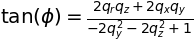

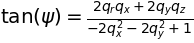

In [13]:
eqs2 = list()
for unknown in euler_angles:
    direct_eqs = list()
    eqs_sincos = list()
    eqs_coscos = list()
    for eq in eqs:
        for row in zip(eq.lhs, eq.rhs):
            lhs, rhs = row
            if not unknown in rhs.atoms():
                #print("Irrelevant for %s: %s" % (unknown, rhs))
                continue

            a, b = zemul(rhs)

            if isinstance(b, sympy.sin) and len(b.args) == 1:
                direct_eqs.append((rhs, lhs))
            elif b.is_Mul and len(b.args) == 2:
                if is_sincos(b, unknown):
                    eqs_sincos.append((rhs, lhs))
                elif is_coscos(b, unknown):
                    eqs_coscos.append((rhs, lhs))
                else:
                    pass
                    #print("Unknown mul for %s: %s" % (unknown, row))
            else:
                pass
                #print("Unknown for %s: %s" % (unknown, row))
    print("")

    if direct_eqs:
        lhs, rhs = direct_eqs[0]
        eqs2.append(sympy.Eq(lhs, rhs))
    elif eqs_sincos and eqs_coscos:
        # Fortunately when iterating on the equations,
        # the sincos/coscos terms always have the same second unknown
        sc, cc = eqs_sincos[0], eqs_coscos[0]
        lhs = (sc[0]/cc[0]).simplify()
        rhs = (sc[1]/cc[1]).subs(q.r**2, 1-q.v[0]**2-q.v[1]**2-q.v[2]**2)
        eqs2.append(sympy.Eq(lhs, rhs))
    else:
        raise NotImplementedError("No good equation for %s" % unknown)

for tmp in eqs2:
    display(tmp)

Now let's "solve":

In [14]:
for eq in eqs2:
    lhs, rhs = eq.lhs, eq.rhs
    a, b = zemul(lhs)
    lhs = a * lhs
    rhs = a * rhs
    if isinstance(b, sympy.tan):
        num = 1
        den = 1
        for arg in rhs.args:
            if arg.is_Pow and arg.args[1] == -1:
                den = den * arg.args[0]
            else:
                num = num * arg
        display(sympy.Eq(b.args[0], sympy.atan2(num, den)))
    elif isinstance(b, sympy.sin):
        display(sympy.Eq(b.args[0], sympy.asin(rhs)))
    else:
        raise NotImplementedError(b)


That's it. Now what remains is to recognize the gimbal lock cases and handle them.